In [35]:
import pandas as pd
import snscrape.modules.twitter as sntwitter
import numpy as np
import nltk
import gensim
from gensim.models import Word2Vec
import spacy
from spacymoji import Emoji
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

nltk.download('wordnet')
nltk.download('omw-1.4')

nlp = spacy.load("pt_core_news_lg")
nlp.add_pipe("emoji", first=True)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/fagnercandido/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/fagnercandido/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [73]:
def get_tweets(query):
    tweets_list = []
    for counter, tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
        tweets_list.append([tweet.date, tweet.url, tweet.username, tweet.content])
    return tweets_list

def get_dataframe_to_twitter(tweets_list):
    return pd.DataFrame(tweets_list, columns=['date', 'url','username', 'content' ])

def add_token_nlp(dataframe):
    return [nlp(text) for text in dataframe.content]

def remove_stop_words_and_return_lemma(dataframe):
    return [[token.lemma_ for token in nlp_token if (not token.is_stop and not token.is_punct and not token.like_num and not token.text == '🤝' and not token.text == '🏻' and not token.text == '👍' and not token.text == '\n' and not token.text == '\n\n' and not token.text == ' ' and not token.text == '🇷' and not token.text == '🇧')] for nlp_token in dataframe.tokens], [[item[0] for item in nlp_token._.emoji] for nlp_token in dataframe.tokens]

def get_list_palavras(dataframe):
    return [item for sublist in dataframe.tokens_without_stop_words for item in sublist], [item for sublist in dataframe.tokens_with_emojis for item in sublist]

def get_most_frequest_palavras(palavras):
    return Counter(palavras).most_common(50)

def get_most_frequent_without_tuple(palavras):
    #zero because the result is a tuple (word, number)
    return [item[0].lower() for item in palavras]

def generate_word_cloud(palavras):
    wordcloud = WordCloud().generate((" ").join(palavras))

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
def generate_word_cloud_emoji(palavras):
    emoji_cloud = EmojiCloud()
    emoji_cloud.generate(palavras)
    
def get_tweets_presidenciaveis(presidenciaveis):
    tweets = []
    for candidato in presidenciaveis:
        tweets.append(get_tweets(candidato))
    return tweets

def get_dataframe_presidenciaveis(tweets):
    dataframes = []
    for tweet in tweets:
         dataframes.append(get_dataframe_to_twitter(tweet))
    return dataframes

def add_column_tokens_in_presidenciaveis(dataframes):
    for dataframe in dataframes:
        dataframe['tokens'] = add_token_nlp(dataframe)
    return dataframes

def add_column_tokens_without_stop_words_in_presidenciaveis(dataframes):
    for dataframe in dataframes:
        tokens_without_stop_words, tokens_with_emojis = remove_stop_words_and_return_lemma(dataframe)
        dataframe['tokens_without_stop_words'] = tokens_without_stop_words
        dataframe['tokens_with_emojis'] = tokens_with_emojis
    return dataframes

def get_presidenciaveis_palavras(dataframes):
    palavras = []
    emojis = []
    for dataframe in dataframes:
        lista_palavras, lista_emojis = get_list_palavras(dataframe)
        palavras.append(lista_palavras)
        emojis.append(lista_emojis)
    return palavras, emojis
        
def get_presidenciaveis_palavras_mais_frequentes(palavras_presidenciaveis, presidenciaveis_emojis):
    palavras_mais_frequentes = []
    emojis_mais_frequentes = []
    for palavras in palavras_presidenciaveis:
        palavras_mais_frequentes.append(get_most_frequest_palavras(palavras))
    
    for emojis in presidenciaveis_emojis:
        emojis_mais_frequentes.append(get_most_frequest_palavras(emojis))
        
    return palavras_mais_frequentes, emojis_mais_frequentes

def get_presidenciaveis_palavras_mais_frequentes_sem_tuplas(palavras_mais_frequentes, emojis_mais_frequentes):
    palavras_mais_frequentes_por_candidato = []
    emojis_mais_frequentes_por_candidato = []
    for palavras in palavras_mais_frequentes:
        palavras_mais_frequentes_por_candidato.append(get_most_frequent_without_tuple(palavras))
        
    for emojis in emojis_mais_frequentes:
        emojis_mais_frequentes_por_candidato.append(get_most_frequent_without_tuple(emojis))
    return palavras_mais_frequentes_por_candidato, emojis_mais_frequentes_por_candidato

In [37]:
presidenciaveis = ['from:jairbolsonaro', 'from:LulaOficial', 'from:simonetebetbr', 'from:cirogomes', 'from:SorayaThronicke', 'from:PeKelmon', 'from:SofiaManzanoPCB', 'from:LeoPericlesUP', 'from:fdavilaoficial']
presidenciaveis_tweets = get_tweets_presidenciaveis(presidenciaveis)

<ipython-input-36-4e617b99f894>:4: FutureWarning: username is deprecated, use user.username instead
  tweets_list.append([tweet.date, tweet.url, tweet.username, tweet.content])


In [39]:
presidenciaveis_dataframes = get_dataframe_presidenciaveis(presidenciaveis_tweets)

In [40]:
for dataframe in presidenciaveis_dataframes:
    dataframe.head()

In [41]:
dataframes = add_column_tokens_in_presidenciaveis(presidenciaveis_dataframes)

In [55]:
dataframes = add_column_tokens_without_stop_words_in_presidenciaveis(dataframes)

In [56]:
presidenciaveis_palavras, presidenciaveis_emojis = get_presidenciaveis_palavras(dataframes)

In [57]:
for index, candidato in enumerate(presidenciaveis):
    print(f'{candidato} com {len(presidenciaveis[index])}')

from:jairbolsonaro com 18
from:LulaOficial com 16
from:simonetebetbr com 18
from:cirogomes com 14
from:SorayaThronicke com 20
from:PeKelmon com 13
from:SofiaManzanoPCB com 20
from:LeoPericlesUP com 18
from:fdavilaoficial com 19


In [58]:
presidenciaveis_palavras_mais_frequentes, presidenciaveis_emojis_mais_frequentes = get_presidenciaveis_palavras_mais_frequentes(presidenciaveis_palavras, presidenciaveis_emojis)

In [66]:
palavras_mais_frequentes_sem_tuplas, emojis_mais_frequentes_sem_tuplas = get_presidenciaveis_palavras_mais_frequentes_sem_tuplas(presidenciaveis_palavras_mais_frequentes, presidenciaveis_emojis_mais_frequentes)

from:jairbolsonaro


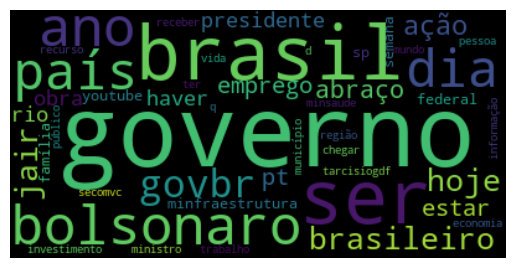

from:LulaOficial


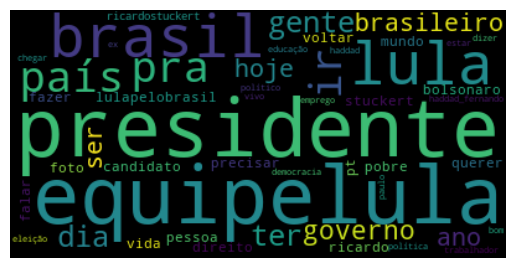

from:simonetebetbr


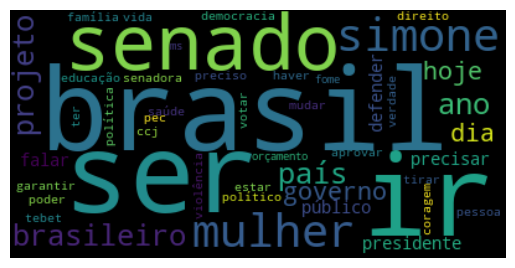

from:cirogomes


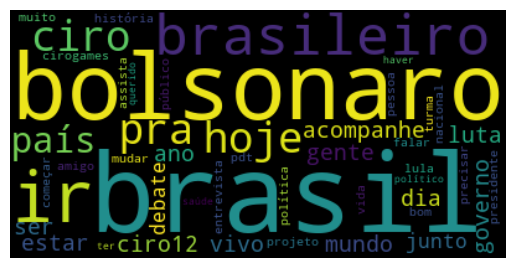

from:SorayaThronicke


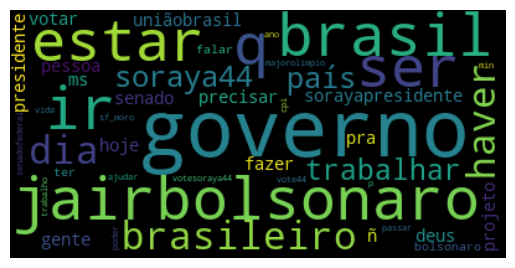

from:PeKelmon


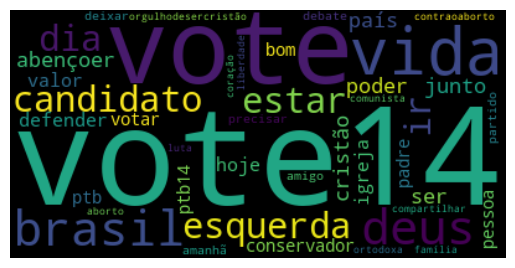

from:SofiaManzanoPCB


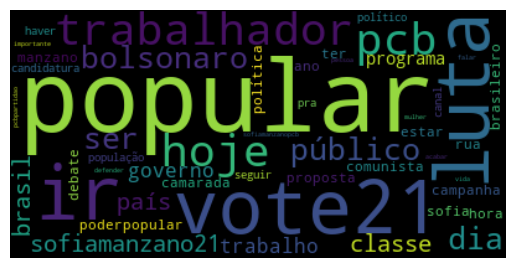

from:LeoPericlesUP


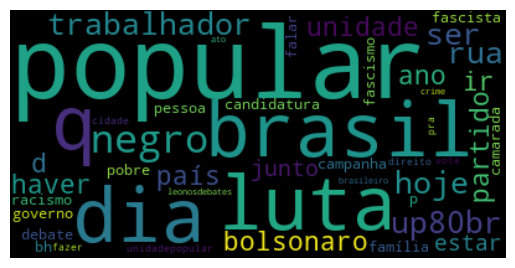

from:fdavilaoficial


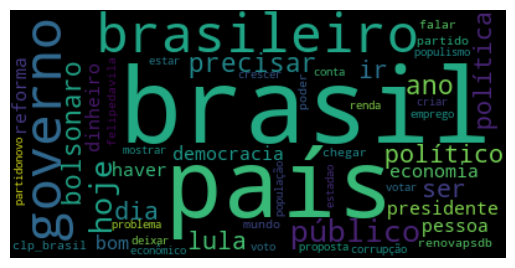

In [67]:
for index, candidato in enumerate(presidenciaveis):
    print(f'{candidato}')
    generate_word_cloud(palavras_mais_frequentes_sem_tuplas[index])

In [74]:
for index, candidato in enumerate(presidenciaveis):
    print(f'{candidato}')
    generate_word_cloud_emoji(emojis_mais_frequentes_sem_tuplas[index])

from:jairbolsonaro


NameError: name 'emojis' is not defined

In [72]:
class EmojiCloud:
    def __init__(self, font_path='Symbola.otf'):
        self.font_path = font_path
        self.word_cloud = self.initialize_wordcloud()
        self.emoji_probability = None

        
    def initialize_wordcloud(self):
        return WordCloud(font_path=self.font_path,
                               width=2000,
                               height=1000,
                               background_color='white',
                               random_state=42,
                               collocations=False)

    
    def color_func(self, word, font_size, position, orientation, random_state=None,
                   **kwargs):
        hue_saturation = '42, 88%'

        current_emoji_probability = self.emoji_probability[word]
        if current_emoji_probability >= 0.10:
            opacity = 50
        else:
            opacity = 75 - current_emoji_probability/0.2 * 5
        return f"hsl({hue_saturation},{opacity}%)"

    def generate(self, text):
        emoji_frequencies = Counter(emojis.iter(text))
        total_count = sum(emoji_frequencies.values())
        
        self.emoji_probability = {emoji: count/total_count for emoji, count in emoji_frequencies.items()}
        wc = self.word_cloud.generate_from_frequencies(emoji_frequencies)
        
        plt.figure(figsize=(20,10))
        plt.imshow(wc.recolor(color_func=self.color_func, random_state=42))
        plt.axis("off")